In [1]:
!apt-get install -y cmake
!pip install opencv-python dlib imutils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 87 not upgraded.


In [2]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 45.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow debug/info/warning logs

In [67]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from tqdm import tqdm
import mediapipe as mp

# MediaPipe Face Mesh setup
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(refine_landmarks=True)

# Landmark indices for eyes and mouth (MediaPipe)
LEFT_EYE = [362, 385, 387, 263, 373, 380]
RIGHT_EYE = [33, 160, 158, 133, 153, 144]
MOUTH = [61, 81, 311, 291, 78, 308, 14, 13]

def show_image(img, title="Image"):
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


W0000 00:00:1748643338.544145     166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1748643338.564007     165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Found 9 images in /kaggle/input/dip-dataset/Imagess/MO
Sample image path: /kaggle/input/dip-dataset/Imagess/MO/IMG-20250530-WA0007.jpg


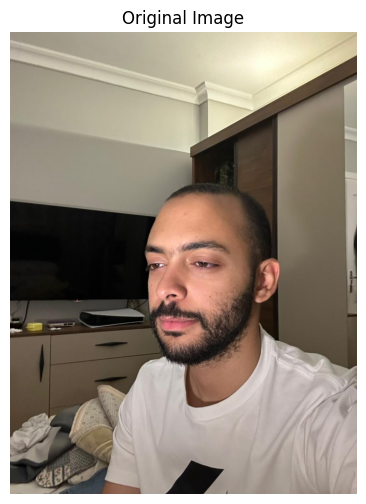

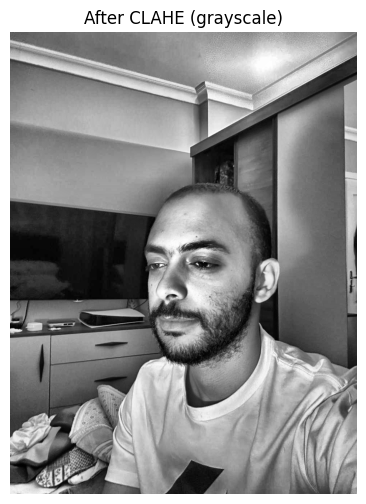

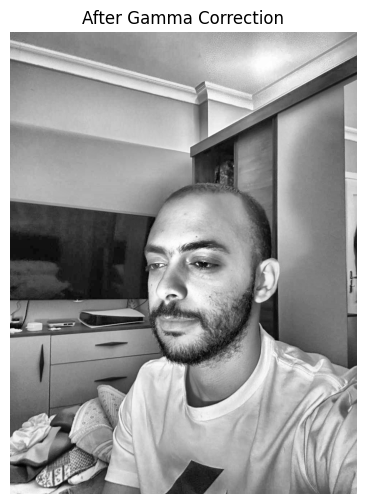

In [68]:
def apply_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    return clahe.apply(gray)

def adjust_gamma(image, gamma=1.3):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(0,256)]).astype("uint8")
    return cv2.LUT(image, table)

# Visualization of preprocessing on a sample image
# Set folder for the person "MO"
image_folder = "/kaggle/input/dip-dataset/Imagess/MO"

# Get all jpg images in that folder
image_paths = glob(os.path.join(image_folder, "*.jpg"))

print(f"Found {len(image_paths)} images in {image_folder}")

# Use the first image path
sample_img_path = image_paths[5]
print("Sample image path:", sample_img_path)

# Now read and process the image
sample_img = cv2.imread(sample_img_path)

show_image(sample_img, "Original Image")

clahe_img = apply_clahe(sample_img)
plt.figure(figsize=(8,6))
plt.title("After CLAHE (grayscale)")
plt.imshow(clahe_img, cmap='gray')
plt.axis('off')
plt.show()

gamma_img = adjust_gamma(clahe_img, gamma=1.3)
plt.figure(figsize=(8,6))
plt.title("After Gamma Correction")
plt.imshow(gamma_img, cmap='gray')
plt.axis('off')
plt.show()

In [74]:
def calculate_ear(landmarks, indices):
    pts = [np.array([landmarks[i].x, landmarks[i].y]) for i in indices]
    A = np.linalg.norm(pts[1] - pts[5])
    B = np.linalg.norm(pts[2] - pts[4])
    C = np.linalg.norm(pts[0] - pts[3])
    ear = (A + B) / (2.0 * C) if C != 0 else 0
    return ear

def calculate_mar(landmarks):
    top = np.array([landmarks[13].x, landmarks[13].y])
    bottom = np.array([landmarks[14].x, landmarks[14].y])
    vertical = np.linalg.norm(top - bottom)
    left = np.array([landmarks[61].x, landmarks[61].y])
    right = np.array([landmarks[291].x, landmarks[291].y])
    horizontal = np.linalg.norm(left - right)
    mar = vertical / horizontal if horizontal != 0 else 0
    return mar

def crop_and_enhance_region(img, landmarks, indices, padding=10, output_size=(128, 128)):
    h, w = img.shape[:2]
    xs = [int(landmarks[i].x * w) for i in indices]
    ys = [int(landmarks[i].y * h) for i in indices]
    
    x_min = max(min(xs) - padding, 0)
    x_max = min(max(xs) + padding, w)
    y_min = max(min(ys) - padding, 0)
    y_max = min(max(ys) + padding, h)
    
    region_crop = img[y_min:y_max, x_min:x_max]
    
    resized = cv2.resize(region_crop, output_size, interpolation=cv2.INTER_CUBIC)
    
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(gray)
    
    enhanced = cv2.GaussianBlur(clahe_img, (3,3), 0)
    enhanced = adjust_gamma(enhanced, gamma=1.3)
    
    return enhanced, (x_min, y_min, x_max, y_max), resized

def analyze_mouth_yawn(img, landmarks, padding=15, output_size=(128, 128)):
    h, w = img.shape[:2]
    xs = [int(landmarks[i].x * w) for i in MOUTH]
    ys = [int(landmarks[i].y * h) for i in MOUTH]

    x_min = max(min(xs) - padding, 0)
    x_max = min(max(xs) + padding, w)
    y_min = max(min(ys) - padding, 0)
    y_max = min(max(ys) + padding, h)
    
    mouth_crop = img[y_min:y_max, x_min:x_max]
    resized = cv2.resize(mouth_crop, output_size, interpolation=cv2.INTER_CUBIC)
    
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    
    top = np.array([landmarks[13].x * w, landmarks[13].y * h])
    bottom = np.array([landmarks[14].x * w, landmarks[14].y * h])
    vertical_dist = np.linalg.norm(top - bottom)
    
    _, thresh = cv2.threshold(enhanced, 70, 255, cv2.THRESH_BINARY_INV)
    white_pixels = cv2.countNonZero(thresh)
    openness_ratio = white_pixels / (enhanced.shape[0] * enhanced.shape[1])
    
    return enhanced, openness_ratio, vertical_dist, resized


In [75]:
def process_person_images(person_folder, max_display=3):
    image_paths = sorted(glob(os.path.join(person_folder, "*.jpg")))
    ears, mars = [], []
    display_count = 0
    
    for img_path in tqdm(image_paths, desc=f"Processing {os.path.basename(person_folder)}"):
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load {img_path}")
            continue
        
        img_clahe = apply_clahe(img)
        img_gamma = adjust_gamma(img_clahe)
        img_rgb = cv2.cvtColor(img_gamma, cv2.COLOR_GRAY2RGB)
        
        results = face_mesh.process(img_rgb)
        
        if results.multi_face_landmarks:
            face = results.multi_face_landmarks[0].landmark
            
            ear_left = calculate_ear(face, LEFT_EYE)
            ear_right = calculate_ear(face, RIGHT_EYE)
            ear = (ear_left + ear_right) / 2
            mar = calculate_mar(face)
            
            ears.append(ear)
            mars.append(mar)
            
            enhanced_left_eye, left_coords, _ = crop_and_enhance_region(img, face, LEFT_EYE)
            enhanced_right_eye, right_coords, _ = crop_and_enhance_region(img, face, RIGHT_EYE)
            enhanced_mouth, mouth_openness, mouth_vertical_dist, _ = analyze_mouth_yawn(img, face)
            
            h, w = img.shape[:2]
            xs = [int(p.x * w) for p in face]
            ys = [int(p.y * h) for p in face]
            x_min, x_max = min(xs), max(xs)
            y_min, y_max = min(ys), max(ys)
            
            annotated = img.copy()
            cv2.rectangle(annotated, (x_min, y_min), (x_max, y_max), (0,255,0), 2)
            cv2.putText(annotated, f"EAR: {ear:.2f}", (x_min, y_min - 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
            cv2.putText(annotated, f"MAR: {mar:.2f}", (x_min, y_min - 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
            cv2.putText(annotated, f"Mouth Openness: {mouth_openness:.2f}", (x_min, y_min - 80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 2)
            cv2.putText(annotated, f"Mouth Dist: {mouth_vertical_dist:.1f}", (x_min, y_min - 100), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 2)
            
            if display_count < max_display:
                show_image(annotated, title=os.path.basename(img_path))
                
                plt.figure(figsize=(5,5))
                plt.imshow(enhanced_left_eye, cmap='gray')
                plt.title(f"Left Eye - {os.path.basename(img_path)}")
                plt.axis('off')
                plt.show()
                
                plt.figure(figsize=(5,5))
                plt.imshow(enhanced_right_eye, cmap='gray')
                plt.title(f"Right Eye - {os.path.basename(img_path)}")
                plt.axis('off')
                plt.show()
                
                plt.figure(figsize=(6,4))
                plt.imshow(enhanced_mouth, cmap='gray')
                plt.title(f"Mouth - {os.path.basename(img_path)} (Openness: {mouth_openness:.2f})")
                plt.axis('off')
                plt.show()
                
                display_count += 1
                
        else:
            ears.append(None)
            mars.append(None)
            print(f"No face detected in {img_path}")
            
    return ears, mars


In [76]:
def calculate_adaptive_thresholds(ears, mars):
    clean_ears = [e for e in ears if e is not None]
    clean_mars = [m for m in mars if m is not None]
    
    if not clean_ears or not clean_mars:
        return 0.25, 0.03  # default thresholds
    
    min_ear = min(clean_ears)
    avg_ear = sum(clean_ears) / len(clean_ears)
    ear_thresh = (min_ear + avg_ear) / 2
    
    avg_mar = sum(clean_mars) / len(clean_mars)
    high_mars = [m for m in clean_mars if m > 0.6]
    mar_thresh = sum(high_mars) / len(high_mars) if high_mars else avg_mar + 0.1
    
    print(f"Adaptive thresholds -> EAR: {ear_thresh:.3f}, MAR: {mar_thresh:.3f}")
    return ear_thresh, mar_thresh


In [77]:
def classify_person_images(person_folder, ear_thresh, mar_thresh, max_display=3):
    image_paths = sorted(glob(os.path.join(person_folder, "*.jpg")))
    results = []
    display_count = 0
    
    for img_path in tqdm(image_paths, desc=f"Classifying {os.path.basename(person_folder)}"):
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        img_clahe = apply_clahe(img)
        img_gamma = adjust_gamma(img_clahe)
        img_rgb = cv2.cvtColor(img_gamma, cv2.COLOR_GRAY2RGB)
        
        results_mp = face_mesh.process(img_rgb)
        
        if results_mp.multi_face_landmarks:
            face = results_mp.multi_face_landmarks[0].landmark
            
            ear_left = calculate_ear(face, LEFT_EYE)
            ear_right = calculate_ear(face, RIGHT_EYE)
            ear = (ear_left + ear_right) / 2
            mar = calculate_mar(face)
            
            enhanced_mouth, mouth_openness, mouth_vertical_dist, _ = analyze_mouth_yawn(img, face)
            
            drowsy_eye = ear < ear_thresh
            drowsy_mouth = (mar > mar_thresh) or (mouth_openness > 0.25) or (mouth_vertical_dist > 20)
            
            label = "Drowsy" if drowsy_eye or drowsy_mouth else "Alert"
            
            h, w = img.shape[:2]
            xs = [int(p.x * w) for p in face]
            ys = [int(p.y * h) for p in face]
            x_min, x_max = min(xs), max(xs)
            y_min, y_max = min(ys), max(ys)
            
            annotated = img.copy()
            cv2.rectangle(annotated, (x_min, y_min), (x_max, y_max), (0,255,0), 2)
            cv2.putText(annotated, f"EAR: {ear:.2f}", (x_min, y_min - 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
            cv2.putText(annotated, f"MAR: {mar:.2f}", (x_min, y_min - 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
            cv2.putText(annotated, f"Mouth Openness: {mouth_openness:.2f}", (x_min, y_min - 80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 2)
            cv2.putText(annotated, f"Status: {label}", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 3)
            
            if display_count < max_display:
                show_image(annotated, title=f"{os.path.basename(img_path)} | {label}")
                display_count += 1
            
        else:
            ear = None
            mar = None
            label = "No face"
        
        results.append({
            "filename": os.path.basename(img_path),
            "ear": ear,
            "mar": mar,
            "label": label
        })
        
    return pd.DataFrame(results)



Processing individual: MO


Processing MO:   0%|          | 0/9 [00:00<?, ?it/s]

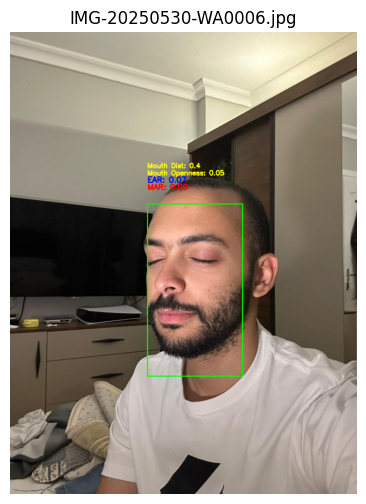

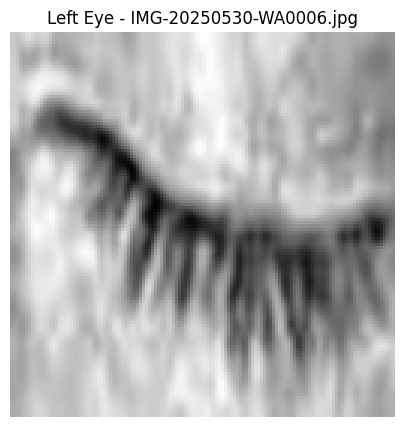

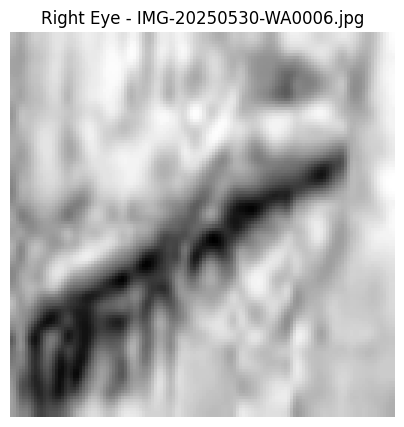

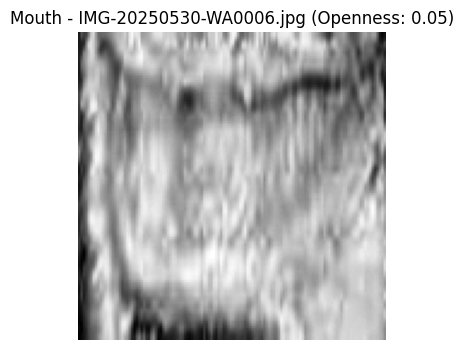

Processing MO:  11%|█         | 1/9 [00:00<00:04,  1.83it/s]

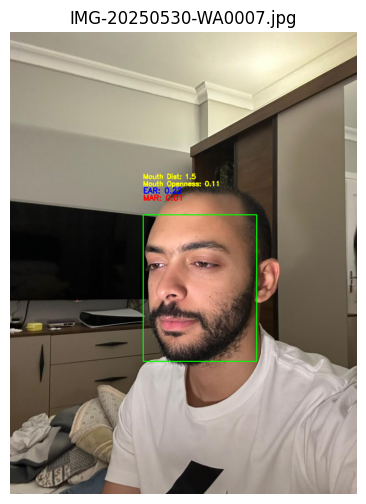

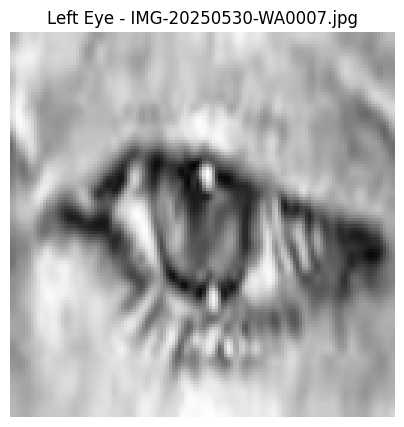

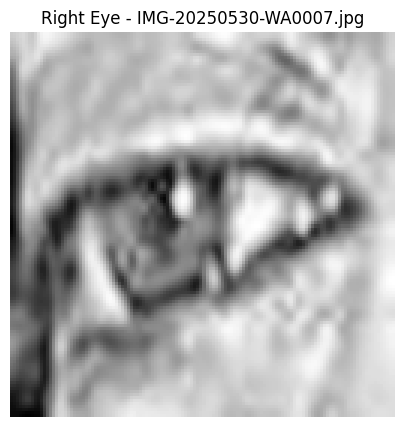

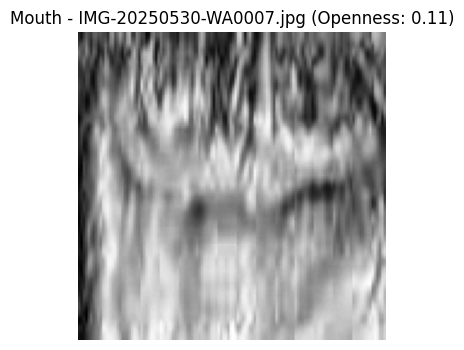

Processing MO:  22%|██▏       | 2/9 [00:01<00:05,  1.29it/s]

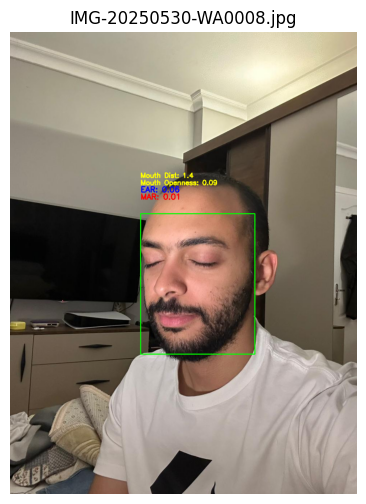

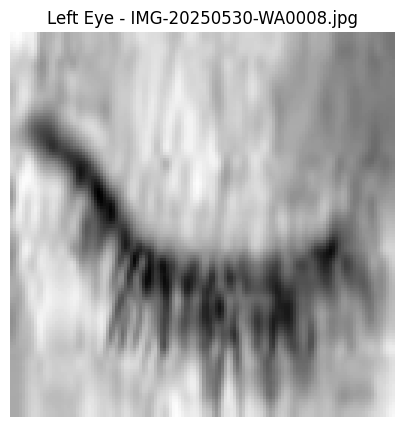

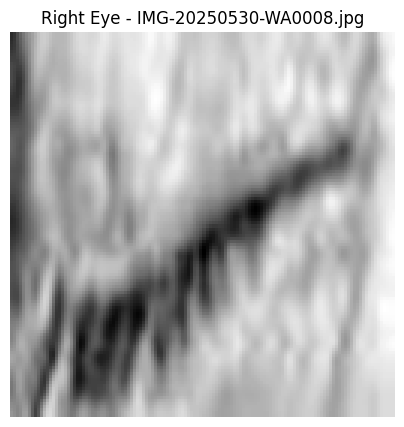

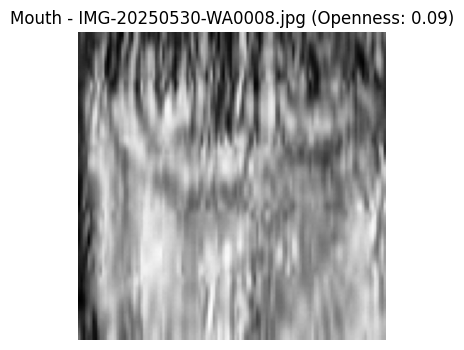

Processing MO: 100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


Adaptive thresholds -> EAR: 0.071, MAR: 0.632


Classifying MO:   0%|          | 0/9 [00:00<?, ?it/s]

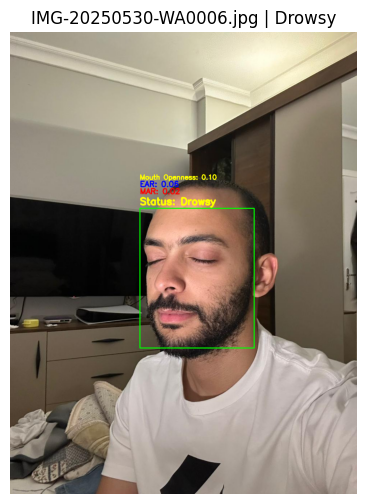

Classifying MO:  11%|█         | 1/9 [00:00<00:02,  3.44it/s]

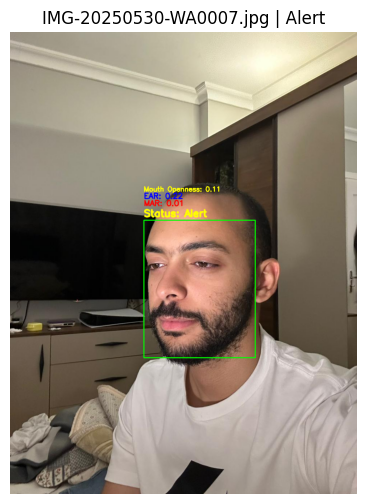

Classifying MO:  22%|██▏       | 2/9 [00:00<00:02,  3.46it/s]

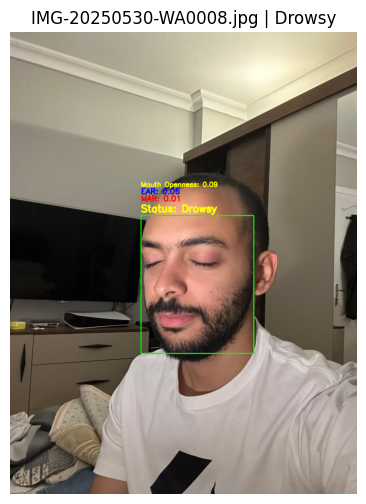

Classifying MO: 100%|██████████| 9/9 [00:01<00:00,  8.71it/s]



Processing individual: OS


Processing OS:   0%|          | 0/11 [00:00<?, ?it/s]

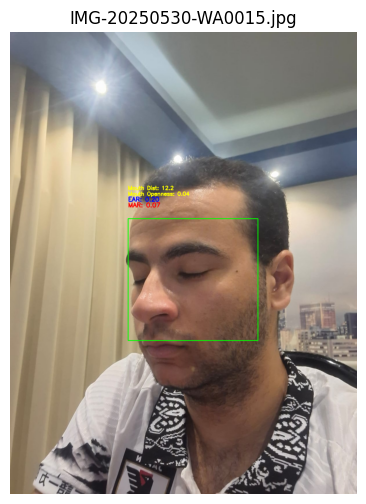

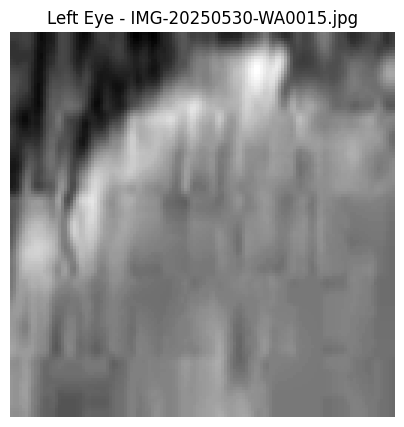

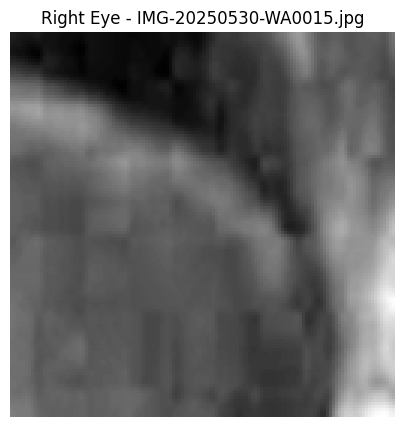

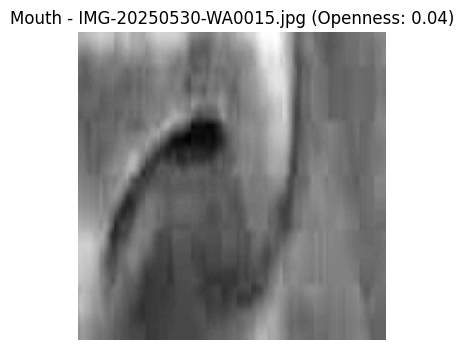

Processing OS:   9%|▉         | 1/11 [00:00<00:06,  1.51it/s]

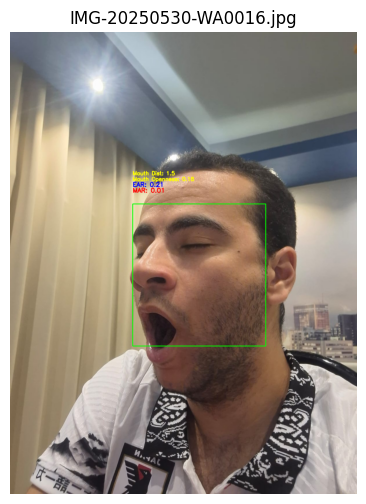

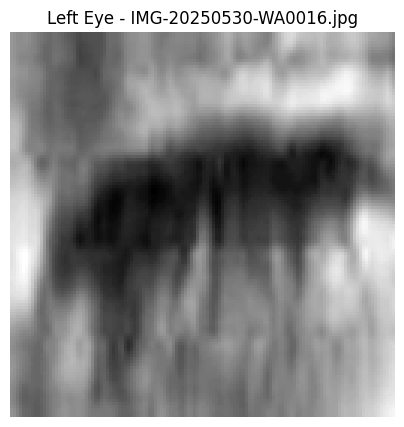

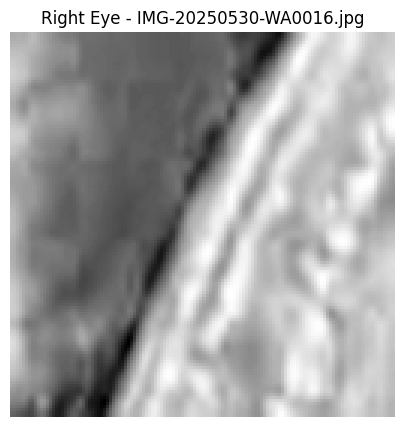

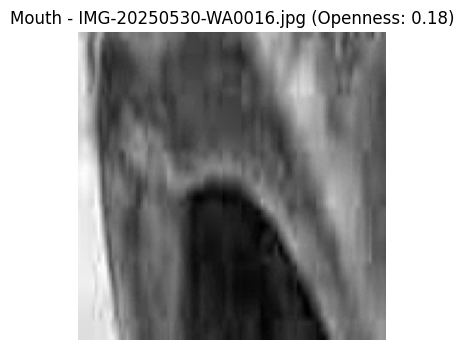

Processing OS:  18%|█▊        | 2/11 [00:01<00:05,  1.58it/s]

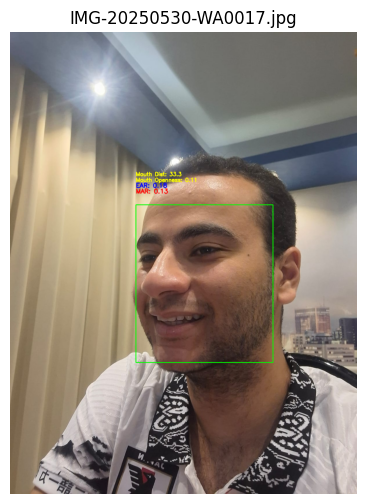

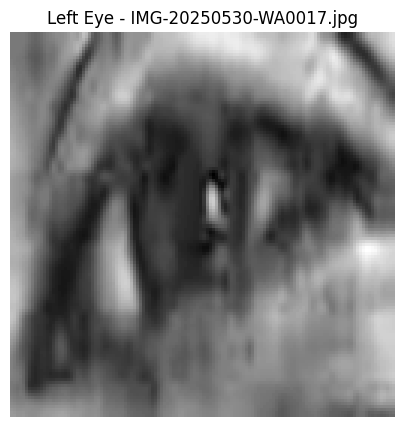

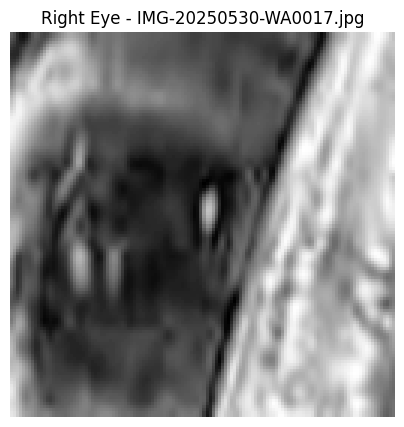

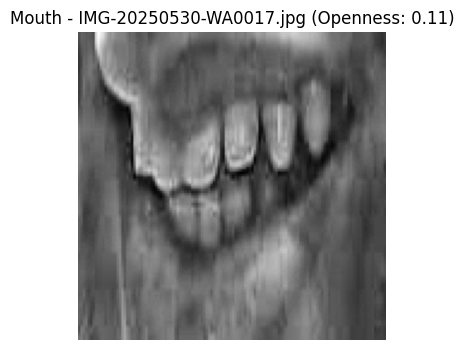

Processing OS: 100%|██████████| 11/11 [00:02<00:00,  5.09it/s]


Adaptive thresholds -> EAR: 0.144, MAR: 0.225


Classifying OS:   0%|          | 0/11 [00:00<?, ?it/s]

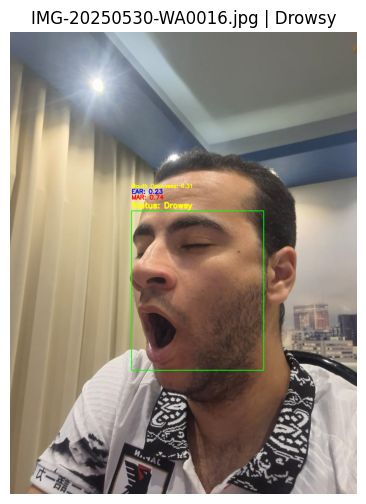

Classifying OS:  18%|█▊        | 2/11 [00:00<00:01,  5.42it/s]

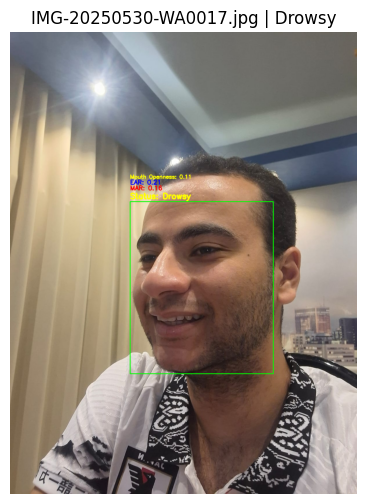

Classifying OS:  27%|██▋       | 3/11 [00:00<00:02,  3.90it/s]

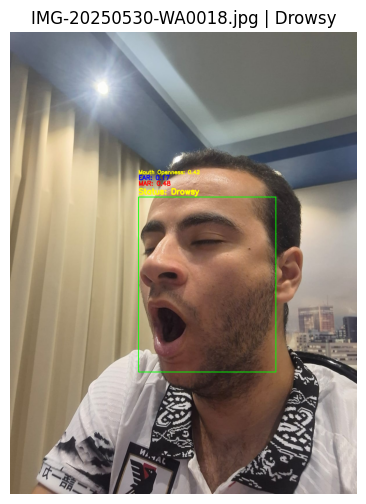

Classifying OS: 100%|██████████| 11/11 [00:01<00:00,  8.26it/s]



Processing individual: Zorkany


Processing Zorkany:   0%|          | 0/12 [00:00<?, ?it/s]

No face detected in /kaggle/input/dip-dataset/Imagess/Zorkany/WIN_20250530_23_12_09_Pro.jpg


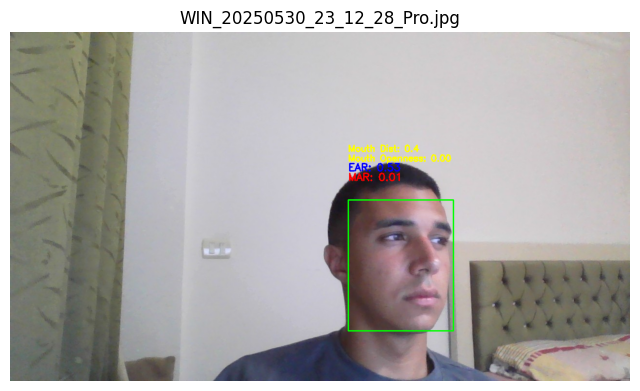

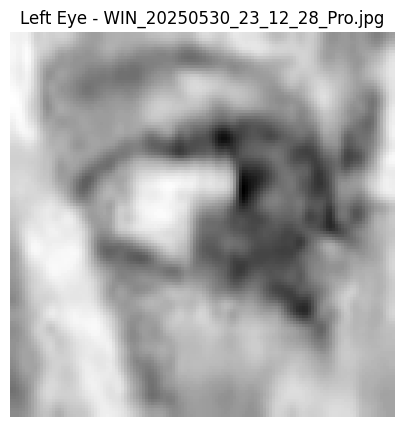

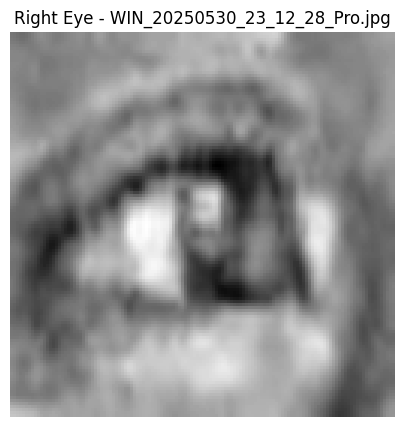

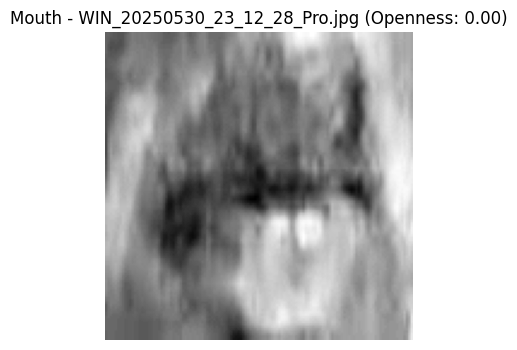

Processing Zorkany:  17%|█▋        | 2/12 [00:00<00:02,  3.54it/s]

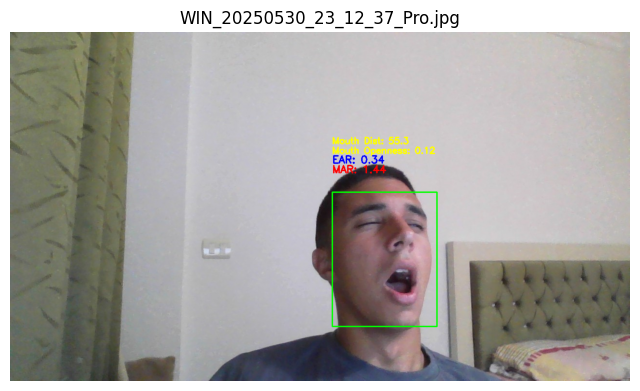

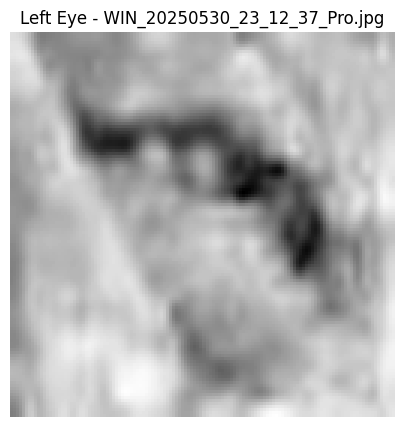

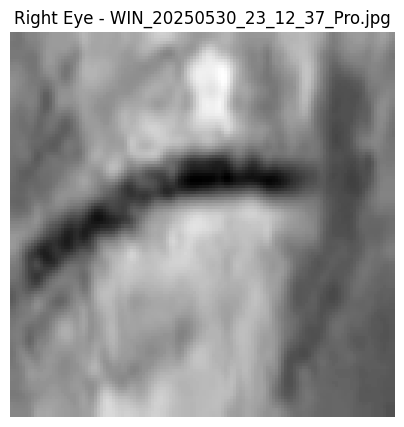

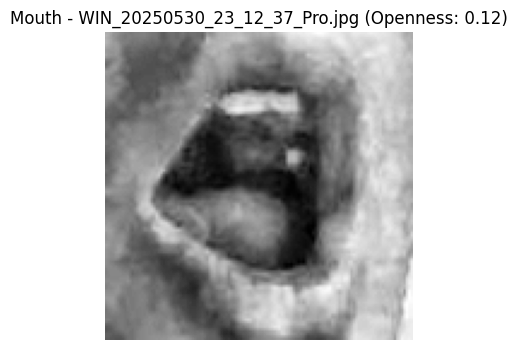

Processing Zorkany:  25%|██▌       | 3/12 [00:01<00:03,  2.50it/s]

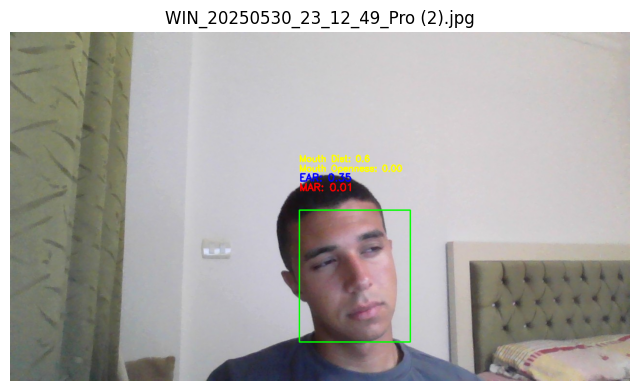

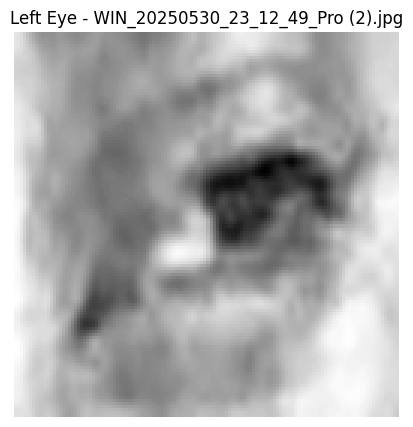

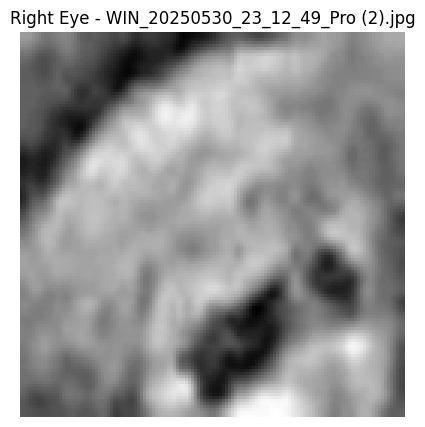

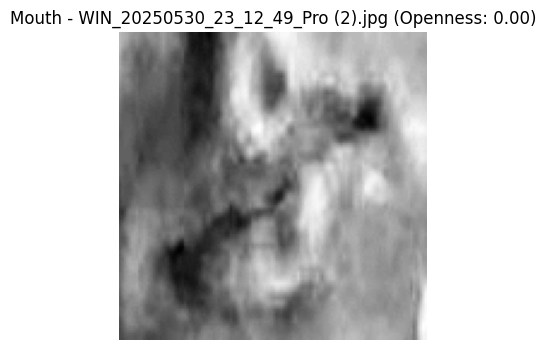

Processing Zorkany: 100%|██████████| 12/12 [00:01<00:00,  6.47it/s]


No face detected in /kaggle/input/dip-dataset/Imagess/Zorkany/WIN_20250530_23_14_02_Pro.jpg
Adaptive thresholds -> EAR: 0.173, MAR: 1.442


Classifying Zorkany:   0%|          | 0/12 [00:00<?, ?it/s]

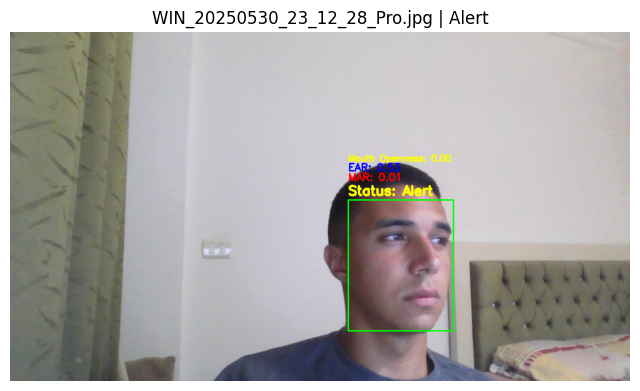

Classifying Zorkany:  17%|█▋        | 2/12 [00:00<00:01,  6.42it/s]

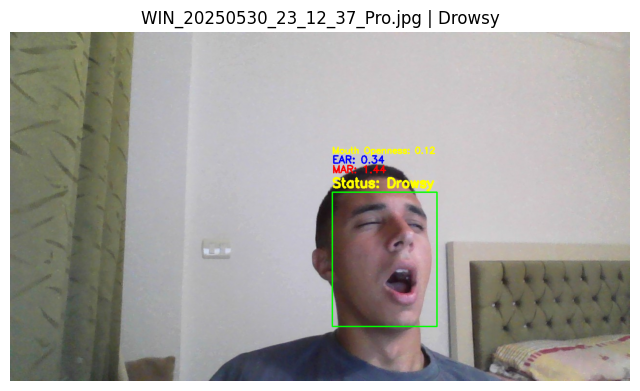

Classifying Zorkany:  25%|██▌       | 3/12 [00:00<00:01,  4.63it/s]

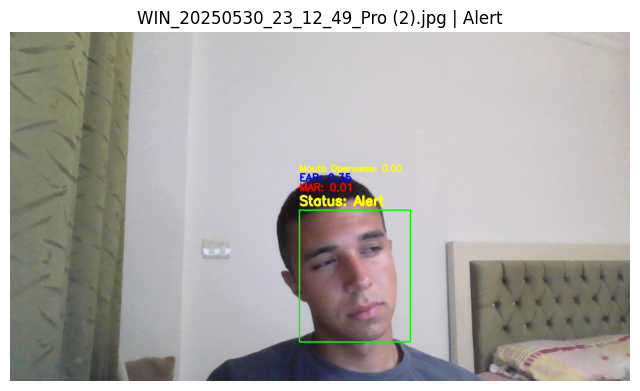

Classifying Zorkany: 100%|██████████| 12/12 [00:01<00:00, 11.15it/s]

Summary of classification results:
                  filename       ear       mar   label person
0  IMG-20250530-WA0006.jpg  0.062271  0.022493  Drowsy     MO
1  IMG-20250530-WA0007.jpg  0.216852  0.007861   Alert     MO
2  IMG-20250530-WA0008.jpg  0.062203  0.006091  Drowsy     MO
3  IMG-20250530-WA0009.jpg  0.065071  0.024541  Drowsy     MO
4  IMG-20250530-WA0010.jpg  0.178781  0.006789   Alert     MO


In [78]:
dataset_base = "/kaggle/input/dip-dataset/Imagess"

persons = [p for p in os.listdir(dataset_base) if os.path.isdir(os.path.join(dataset_base, p))]
all_results = []

for person in persons:
    print(f"\nProcessing individual: {person}")
    folder = os.path.join(dataset_base, person)
    
    ears, mars = process_person_images(folder, max_display=3)
    ear_thresh, mar_thresh = calculate_adaptive_thresholds(ears, mars)
    
    df_person = classify_person_images(folder, ear_thresh, mar_thresh, max_display=3)
    df_person["person"] = person
    
    all_results.append(df_person)

final_results_df = pd.concat(all_results, ignore_index=True)
print("Summary of classification results:")
print(final_results_df.head())
